In [1]:
# simulate_payout_policy.ipynb

import numpy as np
import pandas as pd
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)


# Set parameters
num_creators = 1000
months = pd.date_range(start='2023-01-01', periods=12, freq='MS')
regions = ['US', 'EU', 'Asia']

# simulate base data
rows = []

for creator_id in range(1, num_creators + 1):
    # Each creator has a base earning potential
    base_earning = np.random.normal(loc=80, scale=25)
    base_hours = np.random.normal(loc=40, scale=10)
    region = random.choice(regions)

    for month in months:
        earning = max(0, np.random.normal(loc=base_earning, scale=10))
        hours = max(0, np.random.normal(loc=base_hours, scale=5))
        viewers = max(0, np.random.normal(loc=50, scale=20))

        rows.append([
            creator_id, month, earning, hours, viewers, region
        ])

df = pd.DataFrame(rows, columns=[
    'creator_id', 'month', 'earnings', 'streaming_hours',
    'viewer_count', 'region'
])

# tag policy period
df['policy_period'] = np.where(df['month'] >= '2023-07-01', 'post', 'pre')

In [2]:
# DEFINE TREATED & CONTROL GROUPS
# Average pre-policy earnings per creator
avg_pre = (
    df[df['policy_period'] == 'pre']
    .groupby('creator_id')['earnings']
    .mean()
    .reset_index()
)

# Treated: $50–$100 avg earnings
treated_ids = avg_pre[
    (avg_pre['earnings'] >= 50) & (avg_pre['earnings'] < 100)
]['creator_id'].tolist()

# Control: $100–$150 avg earnings
control_ids = avg_pre[
    (avg_pre['earnings'] >= 100) & (avg_pre['earnings'] < 150)
]['creator_id'].tolist()

# Add flags
df['treated'] = df['creator_id'].apply(lambda x: 1 if x in treated_ids else 0)
df['control'] = df['creator_id'].apply(lambda x: 1 if x in control_ids else 0)

In [3]:
# SIMULATE POLICY EFFECT
df['earnings'] = np.where(
    (df['treated'] == 1) & (df['policy_period'] == 'post'),
    df['earnings'] * 1.10,  # +10% boost for treated group post-policy
    df['earnings']
)

# ADD CHURN FLAG
# Creators active if earnings above $30 threshold
df['active'] = np.where(df['earnings'] > 30, 1, 0)

In [4]:
# SHOW RESULTS
print(df.head())

# Save to CSV for further analysis
df.to_csv('simulated_payout_data.csv', index=False)

print(f" Simulation complete! Rows: {len(df)}. Saved to 'simulated_payout_data.csv'.")

   creator_id      month   earnings  streaming_hours  viewer_count region  \
0           1 2023-01-01  98.894739        46.232506     45.316933   Asia   
1           1 2023-02-01  90.076484        46.513421     65.348695   Asia   
2           1 2023-03-01  87.723110        41.330157     40.731646   Asia   
3           1 2023-04-01  87.760556        39.827168     11.734395   Asia   
4           1 2023-05-01  75.168676        35.805919     29.743378   Asia   

  policy_period  treated  control  active  
0           pre        1        0       1  
1           pre        1        0       1  
2           pre        1        0       1  
3           pre        1        0       1  
4           pre        1        0       1  
 Simulation complete! Rows: 12000. Saved to 'simulated_payout_data.csv'.


In [5]:
import pandas as pd

# Load the CSV
df = pd.read_csv('simulated_payout_data.csv')

# Peek at the first few rows
print(df.head())

# Check shape
print(df.shape)

# Get quick info
print(df.info())

# See if treated/control look right
print(df['treated'].value_counts())
print(df['control'].value_counts())

# Check time range
print(df['month'].min(), df['month'].max())

   creator_id       month   earnings  streaming_hours  viewer_count region  \
0           1  2023-01-01  98.894739        46.232506     45.316933   Asia   
1           1  2023-02-01  90.076484        46.513421     65.348695   Asia   
2           1  2023-03-01  87.723110        41.330157     40.731646   Asia   
3           1  2023-04-01  87.760556        39.827168     11.734395   Asia   
4           1  2023-05-01  75.168676        35.805919     29.743378   Asia   

  policy_period  treated  control  active  
0           pre        1        0       1  
1           pre        1        0       1  
2           pre        1        0       1  
3           pre        1        0       1  
4           pre        1        0       1  
(12000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creator_id       12000 non-null  int64  
 1   mon

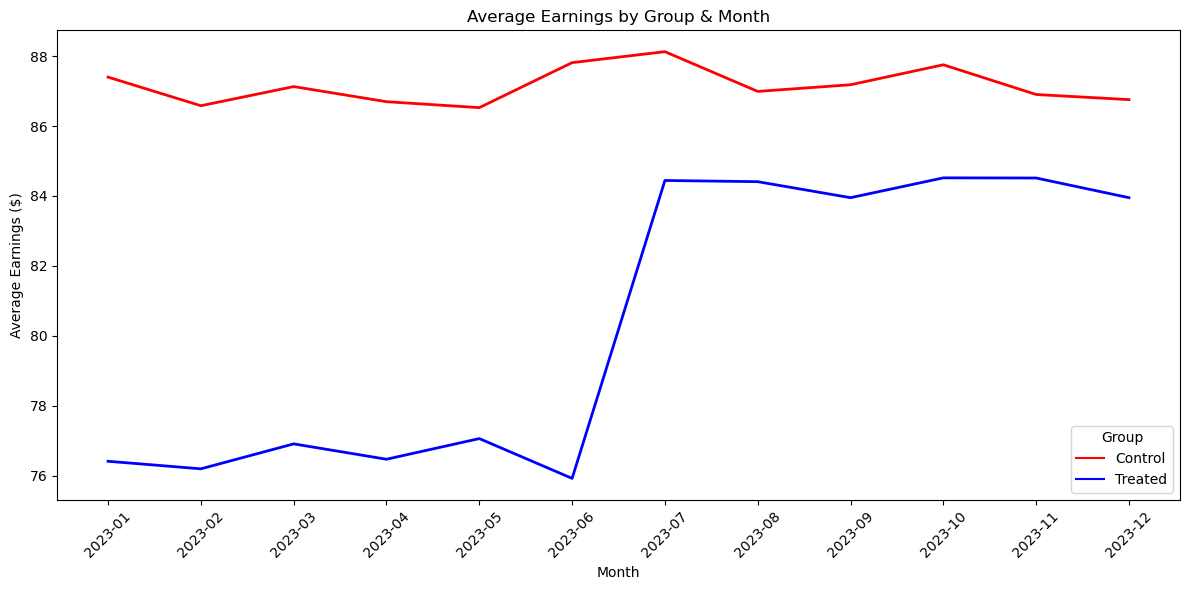

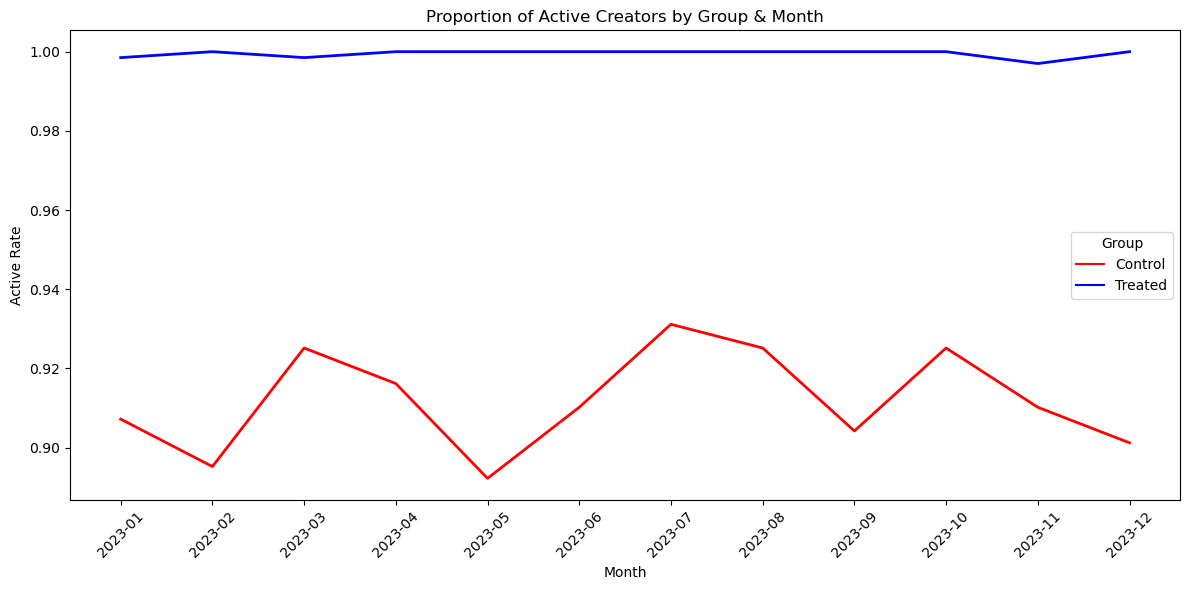

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'month' is datetime and labels are set
df['month'] = pd.to_datetime(df['month'])
df['month_str'] = df['month'].dt.strftime('%Y-%m')
df['group_label'] = df['treated'].map({0: 'Control', 1: 'Treated'})

# 1️⃣ Average earnings by group & month
grouped = df.groupby(['month_str','group_label'])['earnings'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(
    data=grouped,
    x='month_str',
    y='earnings',
    hue='group_label',
    hue_order=['Control','Treated'],
    palette=['red','blue'],
    linewidth=2
)
plt.title('Average Earnings by Group & Month')
plt.xlabel('Month')
plt.ylabel('Average Earnings ($)')
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# 2️⃣ Proportion of active creators by group & month
churn = df.groupby(['month_str','group_label'])['active'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(
    data=churn,
    x='month_str',
    y='active',
    hue='group_label',
    hue_order=['Control','Treated'],
    palette=['red','blue'],
    linewidth=2
)
plt.title('Proportion of Active Creators by Group & Month')
plt.xlabel('Month')
plt.ylabel('Active Rate')
plt.xticks(rotation=45)
plt.legend(title='Group')
plt.tight_layout()
plt.show()


In [7]:
#Difference-in-Differences Estimate

# Average earnings by group & policy period
summary = df.groupby(['treated', 'policy_period'])['earnings'].mean().reset_index()

treated_pre = summary[(summary['treated'] == 1) & (summary['policy_period'] == 'pre')]['earnings'].values[0]
treated_post = summary[(summary['treated'] == 1) & (summary['policy_period'] == 'post')]['earnings'].values[0]

control_pre = summary[(summary['treated'] == 0) & (summary['policy_period'] == 'pre')]['earnings'].values[0]
control_post = summary[(summary['treated'] == 0) & (summary['policy_period'] == 'post')]['earnings'].values[0]

DiD = (treated_post - treated_pre) - (control_post - control_pre)

print(f"--- DiD Summary ---")
print(f"Treated Pre: ${treated_pre:.2f}")
print(f"Treated Post: ${treated_post:.2f}")
print(f"Control Pre: ${control_pre:.2f}")
print(f"Control Post: ${control_post:.2f}")
print(f"Estimated Policy Effect (DiD): ${DiD:.2f} per month")

--- DiD Summary ---
Treated Pre: $76.49
Treated Post: $84.30
Control Pre: $87.02
Control Post: $87.28
Estimated Policy Effect (DiD): $7.54 per month


In [8]:
df.to_csv('simulated_payout_data.csv', index=False)
print("Data exported for Tableau!")

Data exported for Tableau!
